In [ ]:
!wget https://datahack-prod.s3.amazonaws.com/test_file/Test_jPKyvmK.csv
!wget https://datahack-prod.s3.amazonaws.com/train_file/Train_eP48B9k.csv
!wget https://datahack-prod.s3.amazonaws.com/sample_submission/SampleSubmission_XkIpo3X.csv

--2020-09-27 17:38:27--  https://datahack-prod.s3.amazonaws.com/test_file/Test_jPKyvmK.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.44
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1276479 (1.2M) [text/csv]
Saving to: ‘Test_jPKyvmK.csv’

Test_jPKyvmK.csv    100%[===================>]   1.22M   831KB/s    in 1.5s    

2020-09-27 17:38:29 (831 KB/s) - ‘Test_jPKyvmK.csv’ saved [1276479/1276479]

--2020-09-27 17:38:29--  https://datahack-prod.s3.amazonaws.com/train_file/Train_eP48B9k.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.108
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3042783 (2.9M) [text/csv]
Saving to: ‘Train_eP48B9k.csv’

Train_eP48B9k.csv   100%[======

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install rfpimp
!pip install catboost
from sklearn.metrics import mean_absolute_error,accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split,StratifiedShuffleSplit
from rfpimp import *
from tqdm import tqdm
from catboost import *
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

     |████████████████████████████████| 163kB 4.0MB/s 
  Created wheel for rfpimp: filename=rfpimp-1.3.5-cp36-none-any.whl size=10261 sha256=856861f3bd97d04a36a5efe3714500811c2f185d6fe8bf7460a1222e660918c0
  Stored in directory: /root/.cache/pip/wheels/2a/c8/bf/80f91224be00870f84a85aa1782cf6cd62c1289a173b66b8e9
  Created wheel for stratx: filename=stratx-0.5-cp36-none-any.whl size=35033 sha256=26bdadc6e685d4e6be4862396580bd62f8512eef5d9ea75d29bec59e00996cb8
  Stored in directory: /root/.cache/pip/wheels/6e/28/de/a84563cfe761afd6c628e595590455412e26a6c4d587289d7b
Successfully built rfpimp stratx
     |████████████████████████████████| 66.1MB 57kB/s 


In [ ]:
train = pd.read_csv('Train_eP48B9k.csv')
test = pd.read_csv('Test_jPKyvmK.csv')
sub = pd.read_csv('SampleSubmission_XkIpo3X.csv')

In [ ]:
train.head(5)

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0


In [ ]:
test.head(5)

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome
0,id_17231,55.0,retired,married,tertiary,no,7136.0,no,no,cellular,13,aug,90.0,2.0,NaN,0,unknown
1,id_34508,24.0,blue-collar,single,secondary,no,179.0,yes,no,cellular,18,may,63.0,2.0,NaN,0,unknown
2,id_44504,46.0,technician,divorced,secondary,no,143.0,no,no,cellular,8,jul,208.0,1.0,NaN,0,unknown
3,id_174,56.0,housemaid,single,unknown,no,6023.0,no,no,unknown,6,jun,34.0,1.0,NaN,0,unknown
4,id_2115,62.0,retired,married,secondary,no,2913.0,no,no,cellular,12,apr,127.0,1.0,188.0,1,success


In [ ]:
df=train.append(test,ignore_index=True)

In [ ]:
df.isnull().sum(),df.nunique()

(id                                      0
 customer_age                          889
 job_type                                0
 marital                               231
 education                               0
 default                                 0
 balance                               580
 housing_loan                            0
 personal_loan                         223
 communication_type                      0
 day_of_month                            0
 month                                   0
 last_contact_duration                 433
 num_contacts_in_campaign              157
 days_since_prev_campaign_contact    36954
 num_contacts_prev_campaign              0
 prev_campaign_outcome                   0
 term_deposit_subscribed             13564
 dtype: int64, id                                  45211
 customer_age                           79
 job_type                               12
 marital                                 3
 education                              

In [ ]:
df['id']=df.id.str.extract('(\d+)').astype(int)

In [ ]:
df['customer_age']=df['customer_age'].fillna(method='bfill')

In [ ]:
df['marital']=df['marital'].fillna('other')

In [ ]:
df['balance']=df['balance'].fillna(df['balance'].mean())

In [ ]:
df['personal_loan']=df['personal_loan'].fillna('other')

In [ ]:
df['num_contacts_in_campaign']=df['num_contacts_in_campaign'].fillna(-1)

In [ ]:
df['days_since_prev_campaign_contact']=df['days_since_prev_campaign_contact'].fillna(method='bfill')
df['days_since_prev_campaign_contact']=df['days_since_prev_campaign_contact'].fillna(method='ffill')

In [ ]:
df['last_contact_duration']=df['last_contact_duration'].fillna(method='bfill')

In [ ]:
x=['job_type','marital','education','default','housing_loan','personal_loan','communication_type','month','prev_campaign_outcome']
from sklearn.preprocessing import LabelEncoder
for i in x:
  le = LabelEncoder()
  df[i] = le.fit_transform(df[i])
  df[i]=df[i]+1

In [ ]:
df.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,43823,28.0,5,4,3,1,285.0,2,1,3,26,7,303.0,4.0,132.0,0,4,0.0
1,32289,34.0,2,2,2,1,934.0,1,3,1,18,10,143.0,2.0,132.0,1,2,0.0
2,10523,46.0,10,2,2,1,656.0,1,1,1,5,4,101.0,4.0,160.0,0,4,0.0
3,43951,34.0,8,4,2,1,2.0,2,1,3,20,9,127.0,3.0,160.0,0,4,0.0
4,40992,41.0,2,2,1,1,1352.0,2,1,1,13,9,49.0,2.0,160.0,0,4,0.0


In [ ]:
x=['job_type','marital','education','default','housing_loan','personal_loan','communication_type','month','prev_campaign_outcome']
df = pd.get_dummies(df, columns=x)

In [ ]:
train = df[df['term_deposit_subscribed'].isnull()==False]
test = df[df['term_deposit_subscribed'].isnull()==True]
del test['term_deposit_subscribed']

In [ ]:
#bad_labels = train[train['term_deposit_subscribed'] == 0].sample(15000).index
#train = train[~train.index.isin(bad_labels)]

In [ ]:
train['term_deposit_subscribed'].value_counts()

0.0    13253
1.0     3394
Name: term_deposit_subscribed, dtype: int64

In [ ]:
train_df=train.copy()
test_df=test.copy()

# F2

In [ ]:
from math import sqrt 
from sklearn.metrics import f1_score

In [ ]:
X = train_df.drop(labels=['term_deposit_subscribed'], axis=1)
y = train_df['term_deposit_subscribed'].values

#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=2)
#X, y = sm.fit_sample(X, y.ravel())

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=101)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((12485, 54), (12485,), (4162, 54), (4162,))

In [ ]:
categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
categorical_features_indices

array([], dtype=int64)

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         classes_count=2,
                         depth=10,
                         random_seed=121, 
                         iterations=1000, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                        #task_type = 'GPU',
                         od_wait=500)
cat.fit(X_train, y_train, verbose=100,
        use_best_model=True,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        plot=False)
predictions = cat.predict(X_cv)
print('accuracy:', f1_score(y_cv, predictions, average='binary'))

0:	learn: 0.8545819	test: 0.8545819	test1: 0.8502408	best: 0.8502408 (0)	total: 60.9ms	remaining: 1m
100:	learn: 0.9463549	test: 0.9463549	test1: 0.8876808	best: 0.8915050 (86)	total: 4.64s	remaining: 41.3s
200:	learn: 0.9871830	test: 0.9871830	test1: 0.8909011	best: 0.8926184 (117)	total: 9.23s	remaining: 36.7s
300:	learn: 0.9970305	test: 0.9970305	test1: 0.8884981	best: 0.8926184 (117)	total: 13.8s	remaining: 32s
400:	learn: 0.9995193	test: 0.9995193	test1: 0.8899335	best: 0.8926184 (117)	total: 18.4s	remaining: 27.5s
500:	learn: 0.9999199	test: 0.9999199	test1: 0.8908295	best: 0.8926184 (117)	total: 23s	remaining: 22.9s
600:	learn: 1.0000000	test: 1.0000000	test1: 0.8906347	best: 0.8926184 (117)	total: 27.6s	remaining: 18.3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8926184385
bestIteration = 117

Shrink model to first 118 iterations.
accuracy: 0.7382075471698114


In [ ]:
print('accuracy:', f1_score(y_cv, predictions, average='binary'))

accuracy: 0.7382075471698114


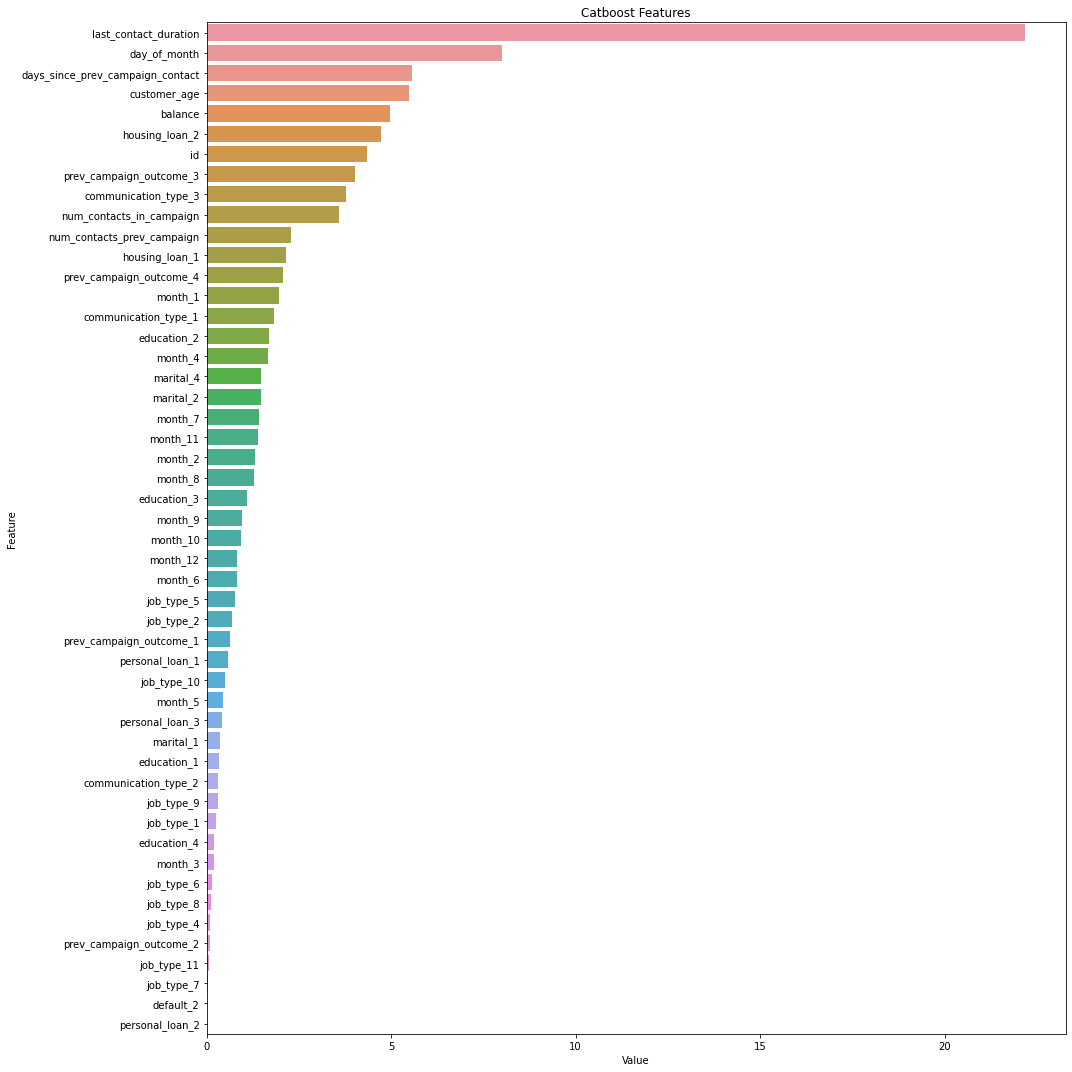

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         classes_count=2,
                         depth=6,
                         random_seed=121, 
                         iterations=3500, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=0.8, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", f1_score(y_test,y_pred_cat, average='weighted'))

    errcat.append(f1_score(y_test,y_pred_cat, average='weighted'))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)

KeyError: ignored

In [ ]:
np.mean(errcat,0)

0.9166737652841915

In [ ]:
cat_final = np.mean(y_pred_totcat,0).round().astype(int)
cat_final

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-9223372036854775808

In [ ]:
xxx = pd.DataFrame(data=cat_final, columns=['term_deposit_subscribed'])

In [ ]:
submission = pd.DataFrame({
        "id":sub['id'],
        "term_deposit_subscribed": xxx['term_deposit_subscribed']
    })
submission.to_csv('./submission.csv', index=False)
print(submission)

             id  term_deposit_subscribed
0      id_17231                        0
1      id_34508                        0
2      id_44504                        0
3        id_174                        0
4       id_2115                        0
...         ...                      ...
13559  id_42406                        0
13560  id_14483                        0
13561  id_43066                        0
13562  id_18375                        0
13563  id_12898                        0

[13564 rows x 2 columns]


In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# f4

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
df_train = train_df
df_test = test_df

In [ ]:
X_train = train_df.drop(['term_deposit_subscribed'],axis=1)
y_train = train_df['term_deposit_subscribed']

In [ ]:
x=[]
for i in test_df.columns:
  x.append(i)
x=np.array(x)
x

array(['id', 'customer_age', 'balance', 'day_of_month',
       'last_contact_duration', 'num_contacts_in_campaign',
       'days_since_prev_campaign_contact', 'num_contacts_prev_campaign',
       'job_type_1', 'job_type_2', 'job_type_3', 'job_type_4',
       'job_type_5', 'job_type_6', 'job_type_7', 'job_type_8',
       'job_type_9', 'job_type_10', 'job_type_11', 'job_type_12',
       'marital_1', 'marital_2', 'marital_3', 'marital_4', 'education_1',
       'education_2', 'education_3', 'education_4', 'default_1',
       'default_2', 'housing_loan_1', 'housing_loan_2', 'personal_loan_1',
       'personal_loan_2', 'personal_loan_3', 'communication_type_1',
       'communication_type_2', 'communication_type_3', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'prev_campaign_outcome_1', 'prev_campaign_outcome_2',
       'prev_campaign_outcome_3', 'prev_campaign_outcome_4'], dtype='<U

In [ ]:
feats=x

In [ ]:
splits = 15
folds =StratifiedKFold(n_splits=splits, random_state=42,shuffle=True)
oof_preds = np.zeros((len(df_test), 2))
feature_importance_df = pd.DataFrame()
feature_importance_df['Feature'] = X_train.columns
final_preds = []
random_state = [22,44,66,77,88,99,101]
counter = 0

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values,y_train)):
        print("iter_ {}".format(fold_))
        X_trn,y_trn = X_train[feats].iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train[feats].iloc[val_idx],y_train.iloc[val_idx]
        clf = lgb.LGBMClassifier(boosting='gbdt',learning_rate=0.1, n_estimators=1000, random_state=101, subsample=0.9,max_depth=-1,num_leaves=31)#
         #,
         #min_data_in_leaf=11,
         #bagging_fraction=0.90,
         #bagging_freq=2,
         #bagging_seed=3,
         #feature_fraction=0.90,
         #feature_fraction_seed=2,
         #early_stopping_round=200,
         #max_bin=1000)#(n_estimators=1000,max_depth=4,random_state=42)#dart
        clf.fit(X_trn, y_trn,eval_set=[(X_trn, y_trn), (X_val, y_val)],verbose=0,
                eval_metric='multi_error',early_stopping_rounds=100)
        
        imp = importances(clf,X_val,y_val)
        imp.rename(columns={'Importance':f'Importance_{fold_}'},inplace=True)
        feature_importance_df = pd.merge(feature_importance_df,imp,on='Feature')
        final_preds.append(accuracy_score(y_pred=clf.predict(X_val),y_true=y_val))
        
        oof_preds += clf.predict_proba(df_test[feats])
oof_preds = oof_preds/splits
print(sum(final_preds)/splits)

iter_ 0
iter_ 1
iter_ 2
iter_ 3
iter_ 4
iter_ 5
iter_ 6
iter_ 7
iter_ 8
iter_ 9
iter_ 10
iter_ 11
iter_ 12
iter_ 13
iter_ 14
0.9039591583912914


In [ ]:
preds_x = [np.argmax(x) for x in oof_preds]

In [ ]:
submission = pd.DataFrame({
        "id":sub['id'],
        "term_deposit_subscribed": preds_x
    })
submission.to_csv('./submission.csv', index=False)
print(submission)

             id  term_deposit_subscribed
0      id_17231                        0
1      id_34508                        0
2      id_44504                        0
3        id_174                        0
4       id_2115                        1
...         ...                      ...
13559  id_42406                        0
13560  id_14483                        0
13561  id_43066                        0
13562  id_18375                        0
13563  id_12898                        0

[13564 rows x 2 columns]


In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# f3

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib as mpl

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

In [ ]:
X = train_df.drop(columns=['term_deposit_subscribed'])
y = train_df.term_deposit_subscribed

In [ ]:
print('Percentage of each class in Target Variable \n')
print((train_df.term_deposit_subscribed.value_counts()/len(train_df))*100)

Percentage of each class in Target Variable 

0.0    84.321153
1.0    15.678847
Name: term_deposit_subscribed, dtype: float64


In [ ]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, max_features=0.7 , bootstrap=False)
cross_val_score(rfc, X, y, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted').mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


0.888978550997914

In [ ]:
y = train_df.term_deposit_subscribed
corr = pd.concat(objs=[X, y], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(5)

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [ ]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

In [ ]:
steps = [('over', SMOTE()), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [ ]:
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.918
